In [52]:
# imports and functions, does nothing

from IPython.display import Image
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from json import JSONEncoder
import json

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

def serialize(uri, o, version=''):
    try:
        os.remove(".cache/"+uri)
    except:
        pass
    with open(".cache/"+uri, "w") as f:
        if version != '':
            f.write('#version: '+version+'\n')
        json.dump(o, f, cls=NumpyArrayEncoder)

def deserialize(uri, version=''):
    if os.path.isfile(".cache/"+uri):
        with open(".cache/"+uri, "r") as f:
            data = []
            for line in f:
                if not line.startswith('#version:'):
                    data.append(line)
            return json.loads(''.join(data))
    return None

def load_or_compute(uri, compute_function, rebuild=False):
    data = None
    if not rebuild:
        data = deserialize(uri)
    if data is None:
        data = compute_function()
        serialize(uri, data)
        return data
    return data

def img(path, width=400):
    rnd = random.randint(0,2e9)
    return f"""<img src="{path}?nocache={rnd}" style="width:{width}px; "></img>"""

In [2]:
data_all = np.load('quic-100p-338-40-loops-har.npy', allow_pickle=True).item()
data = data_all['both'] # adblock + decentraleyes
urls = [url for url in data]

In [46]:
from lib.features import *
from lib.rf import *

In [12]:
# filters data -> data_matching, for X=2

X = 2
urls_len_matching = [row for row in number_of_subresources if round(row[1]) == 2]
urls_matching = [row[0] for row in urls_len_matching]
print(f"There are {len(urls_matching)} websites which load == {X} subresources.")

data_matching = dict()
for row in urls_len_matching:
    url, count = row
    data_matching[url] = data[url]
    print(url, count)

There are 12 websites which load == 2 subresources.
apiexpossandbox.mile.app 1.675
smileytoysandgames.com 1.725
publyads.jstag.space 1.775
ronbpost.com 1.975
binaryws.com 2.0
cialisdr.com 2.0
viaagra1.com 2.051282051282051
muk-toon.com 2.075
thanesamikshak.in 2.3
www.thaitoon.net 2.3421052631578947
venona.com 2.3846153846153846
myegypthost.com 2.388888888888889


Text(0, 0.5, 'Total Incoming [B]')

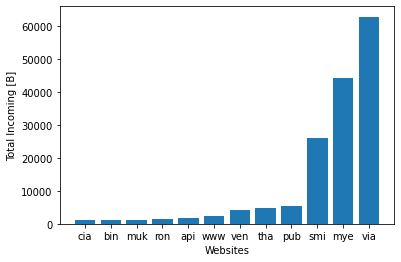

In [16]:
# total incoming size
incoming_bytes = []
incoming_bytes_per_website = dict()

for url in data_matching:
    incoming_bytes_for_this_website = []

    for sample in data[url]:
        for request in data[url][sample]:
            t, out, inc = request
            incoming_bytes.append(abs(inc))
            incoming_bytes_for_this_website.append(abs(inc))

    incoming_bytes_per_website[url] = np.mean(incoming_bytes_for_this_website)

tuples = list(incoming_bytes_per_website.items())
tuples.sort(key=lambda row: row[1])

xs = [t[0][:3] for t in tuples]
ys = [int(t[1]) for t in tuples]

plt.bar(np.arange(len(ys)), ys)
plt.xticks(np.arange(len(ys)), xs)
plt.xlabel('Websites')
plt.ylabel('Total Incoming [B]')
#plt.yscale('log')
#plt.ylim([0, 10000])

In [39]:
# compute optimal padding functions based on incoming sizes

incoming_bytes.sort()
incoming_bytes = [x for x in incoming_bytes if x > 2] # 0 and 1 are special case that correspond to blocked resources

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def find_cost(data, padding_function_steps):
    costs = []
    # data is sorted, so i is never decreasing
    i = 0
    for x in data:
        pad_to = padding_function_steps[i]
        while x > pad_to:
            i += 1
            pad_to = padding_function_steps[i]
        costs.append(pad_to - x)
    return costs


def find_optimal_pad(data, n_cut): # data must be sorted
    size_of_cut = math.ceil(len(data) / n_cut)
    chunked = chunks(data, size_of_cut)
    cuts = [chunk[-1] for chunk in chunked]
    costs = find_cost(data, cuts)

    return cuts, np.median(costs), np.mean(costs)

def build_padding_functions():
    padding_functions = []
    prev_n_cuts = -1
    for cut in range(1, 200):
        cuts, med_cost, mean_cost = find_optimal_pad(incoming_bytes, cut)
        if len(cuts) == prev_n_cuts:
            continue
        prev_n_cuts = len(cuts)
        padding_functions.append([cuts, med_cost, mean_cost])
    return padding_functions

padding_functions = load_or_compute("pad_fn.X=2.npy", build_padding_functions, rebuild=True)

for cut, med_cost, mean_cost in padding_functions:
    print(med_cost, cut)


167213.0 [169136]
1286.0 [1919, 169136]
570.0 [979, 2603, 169136]
480.0 [858, 1927, 2961, 169136]
432.0 [835, 1461, 2300, 3343, 169136]
193.0 [824, 979, 1919, 2603, 13816, 169136]
316.0 [809, 882, 1742, 2110, 2919, 27699, 169136]
207.5 [765, 858, 1264, 1927, 2340, 2961, 35750, 169136]
116.0 [749, 846, 979, 1762, 2094, 2603, 3343, 35784, 169136]
150.5 [745, 836, 896, 1463, 1968, 2302, 2907, 3343, 35796, 169136]
153.0 [741, 830, 875, 1264, 1808, 2056, 2485, 2933, 13789, 57951, 169136]
95.5 [728, 825, 859, 981, 1738, 1953, 2246, 2603, 2962, 13822, 71783, 169136]
89.0 [720, 815, 848, 942, 1264, 1853, 2033, 2312, 2889, 3343, 23301, 76334, 169136]
85.0 [720, 809, 840, 884, 1264, 1746, 1986, 2118, 2532, 2923, 3343, 27745, 93861, 169136]
82.5 [720, 791, 835, 871, 979, 1461, 1861, 2033, 2300, 2603, 2947, 3343, 35726, 93775, 169136]
54.0 [720, 765, 832, 858, 944, 1264, 1750, 1927, 2098, 2340, 2637, 2961, 13774, 35750, 93876, 169136]
50.0 [720, 755, 829, 852, 894, 1264, 1730, 1895, 2033, 2282, 25

In [55]:
def next_val(x, padding_function_steps):
    i = 0
    pad_to = padding_function_steps[i]
    while x > pad_to:
        i += 1
        if i >= len(padding_function_steps):
            print(x, padding_function_steps)
        pad_to = padding_function_steps[i]
    return padding_function_steps[i]


def pad_to_cuts(data, cuts):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                t, out, inc = request
                out = 600 # pad all requests
                data2[url][sample].append([t, out, next_val(inc, cuts)])
    return data2


def build_data_matching():
    data_matching = {}
    urls_matching = [url for url, nsubresources in number_of_subresources if int(nsubresources) == 2]
    for url in urls_matching:
        data_matching[url] = dict()
        for sample in data[url]:
            this_sample = data[url][sample]
            filtered_sample = [sample for sample in this_sample if sample[2] != -1]
            if len(filtered_sample) == X:
                data_matching[url][sample] = filtered_sample
    return data_matching

data_matching = load_or_compute("data_matching.X=2.npy", build_data_matching, rebuild=False)

def build_clf_perfs():
    clf_perfs = {}
    for cuts, med_cost, mean_cost in padding_functions:
        print(f"***************** Working on n cuts: {len(cuts)}")
        data_padded = pad_to_cuts(data_matching, cuts)
        features = get_features(data_padded)
        clf_res = rf_with_rfe(features)

        clf_perfs[len(cuts)] = clf_res
    return clf_perfs

clf_perfs = load_or_compute("clf_perfs.X=2.npy", build_clf_perfs, rebuild=True)


***************** Working on n cuts: 1
Skipping muk-toon.com only 17 samples
Skipping venona.com only 16 samples
Skipping uywtvbmw.coolmaterial.com only 10 samples
Skipping 358.nbryb.com only 0 samples
Skipping 44.nbryb.com only 0 samples
Skipping asoom-ooo.blogspot.com only 5 samples
Skipping 312.nbryb.com only 1 samples
[feature_extract] Number of classes 6
[feature_extract] Number of features 123
[feature_extract] Number of samples 168
[feature_extract] Number of labels 168
Number of classes 6
Number of features 123
Number of samples 168
Number of labels 168
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
***************** Working on n cuts: 2
Skipping muk-toon.com only 17 samples
Skipping venona.com only 16 samples
Skipping uywtvbmw.coolmaterial.com only 10 samples
Skipping 358.nbryb.com only 0 samples
Skipping 44.nbryb.com only 0 samples
Skipping asoom-ooo.blogspot.com only 5 samples
Skipping 312.nbryb.com only 1 samples
[feature_extract] Number of classes 6


In [56]:
last_size = 0
for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perfs: # if the attack was not run, skip
        continue
    if len(cuts) == last_size: # skips repeat due to rounding in np.linrange
        continue

    last_size = len(cuts)
    acc = round(clf_perfs[len(cuts)]['score']['accuracy'][0], 2)
    top_f = [feature_name for feature_name, *_ in clf_perfs[len(cuts)]['features'][:10]]
    med_cost_str = f"{round(med_cost)} B"
    if med_cost > 1024:
        med_cost_str = f"{round(med_cost/1024)} kB"
    print(f"steps: {len(cuts)}, mean extra cost/subresource {med_cost_str}, acc {acc}, features: {top_f}")

steps: 1, mean extra cost/subresource 163 kB, acc 0.58, features: ['time_outgoing_p25', 'time_incoming_p100', 'time_p100', 'time_outgoing_p75', 'intertime_incoming_p75', 'intertime_avg', 'intertime_outgoing_avg', 'intertime_p75', 'time_outgoing_p100', 'time_incoming_p75']
steps: 2, mean extra cost/subresource 1 kB, acc 0.72, features: ['bytes_%_in', 'time_incoming_p100', 'time_outgoing_p50', 'time_incoming_p75', 'time_p25', 'time_incoming_p50', 'intertime_p75', 'intertime_incoming_avg', 'intertime_outgoing_avg', 'time_p100']
steps: 3, mean extra cost/subresource 570 B, acc 0.85, features: ['time_incoming_p75', 'time_p100', 'time_outgoing_p50', 'bytes_%_in', 'time_incoming_p100', 'time_incoming_p50', 'bytes_incoming', 'bytes_%_out', 'time_incoming_p25', 'bytes_total']
steps: 4, mean extra cost/subresource 480 B, acc 0.9, features: ['time_incoming_p100', 'bytes_%_out', 'time_p100', 'bytes_%_in', 'time_incoming_p50', 'bytes_incoming', 'time_outgoing_p50', 'intertime_outgoing_p75', 'hist_1

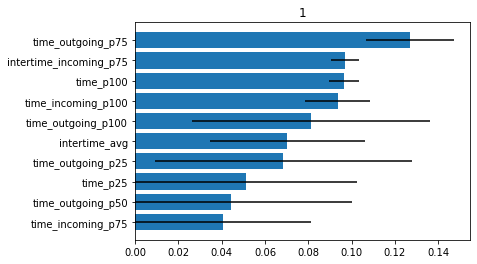

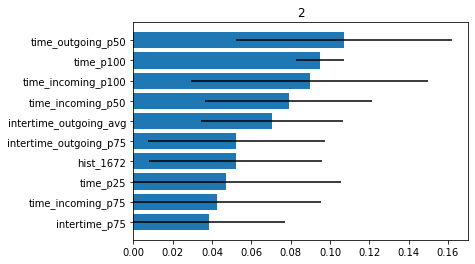

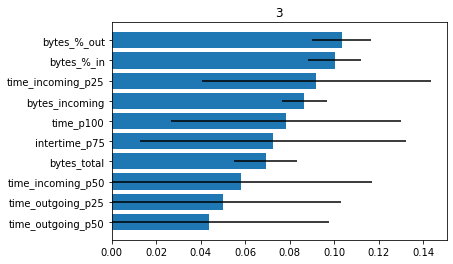

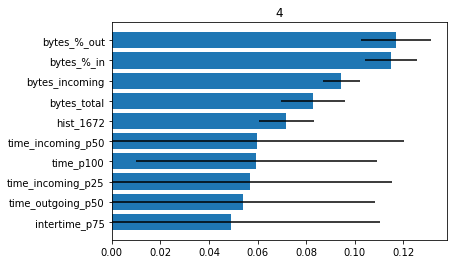

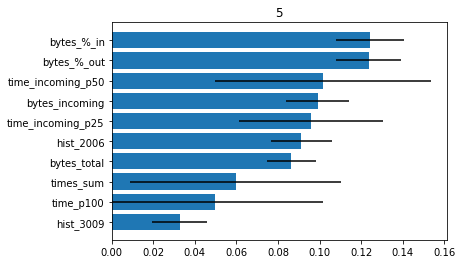

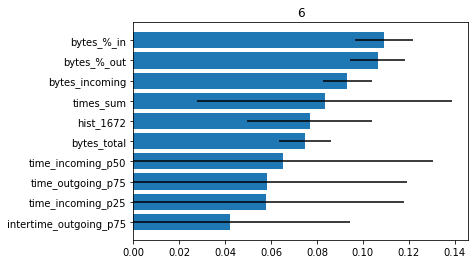

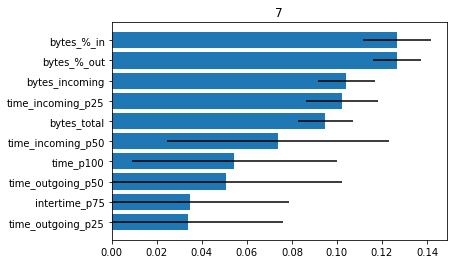

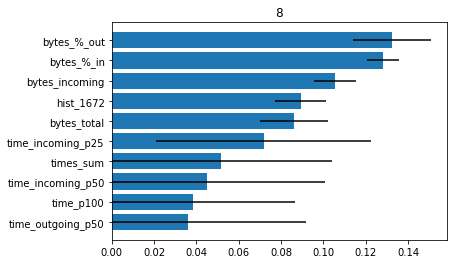

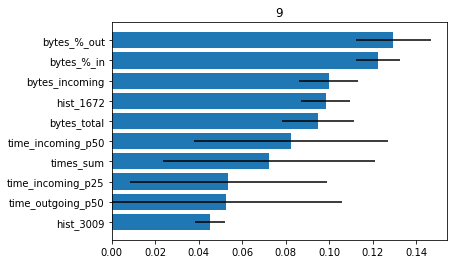

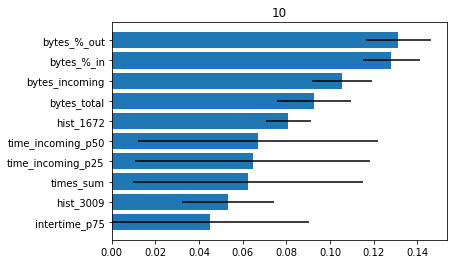

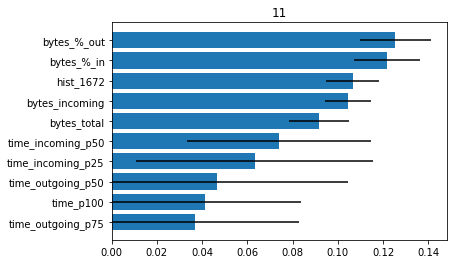

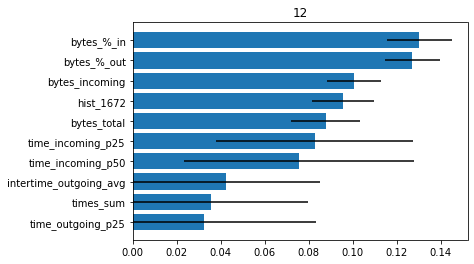

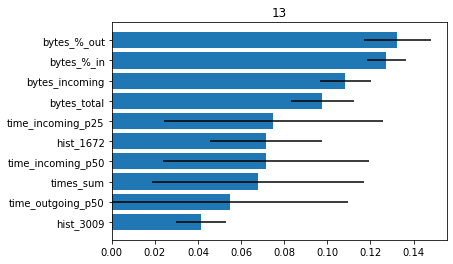

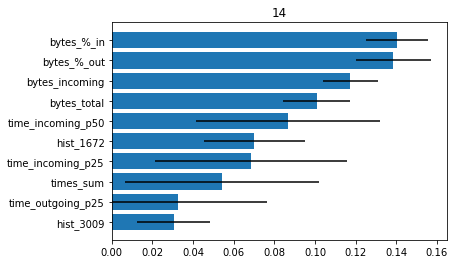

In [57]:
def plot_fi(features_of_interest, title):
    features_of_interest.sort(key=lambda row: row[1], reverse=True) # truncate top ten
    features_of_interest = features_of_interest[:10]
    features_of_interest.sort(key=lambda row: row[1], reverse=False) # plotting needs ascending order

    xs = [x[0] for x in features_of_interest]
    ys = [y[1] for y in features_of_interest]
    yerr = [[min(y[1], y[2]) for y in features_of_interest], [y[2] for y in features_of_interest]]

    plt.barh(xs, ys, xerr=yerr)
    plt.title(title)
    plt.show()
    
    
last_size = 0
cuts_vs_med_cost_acc = []

for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perfs: # if the attack was not run, skip
        continue
    if len(cuts) == last_size: # skips repeat due to rounding in np.linrange
        continue

    last_size = len(cuts)
    acc = round(clf_perfs[len(cuts)]['score']['accuracy'][0], 2)
    top_f = [feature_name for feature_name, *_ in clf_perfs[len(cuts)]['features'][:10]]

    cuts_vs_med_cost_acc.append([len(cuts), med_cost, acc])

    # also plot for the first 15 results
    if len(cuts) < 15:
        plot_fi(clf_perfs[len(cuts)]['features'], title=len(cuts))


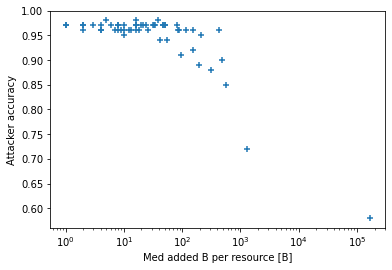

In [60]:
len_cuts = [row[0] for row in cuts_vs_med_cost_acc]
med_costs = [row[1] for row in cuts_vs_med_cost_acc]
accs = [row[2] for row in cuts_vs_med_cost_acc]

plt.scatter(med_costs, accs, marker="+")
plt.ylabel("Attacker accuracy")
plt.xlabel("Med added B per resource [B]")
plt.xscale('log')

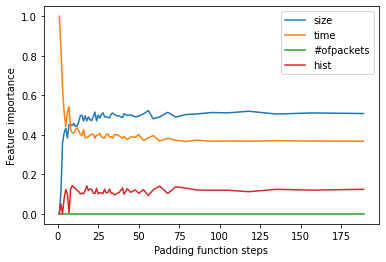

In [61]:
# understand how features evolve
def find_importance(features_and_importance, feature_name):
    for feature, importance, _ in features_and_importance:
        if feature == feature_name:
            return importance

    return 0

def sum_all_matching(features_and_importance, keyword):
    su = 0
    for feature, importance, _ in features_and_importance:
        if keyword in feature:
            su += importance

    return su

tuples = []
for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perfs: # if the attack was not run, skip
        continue

    features = clf_perfs[len(cuts)]['features']
    #print(len(cuts), sum_all_matching(features, "byte"), sum_all_matching(features, "time"), sum_all_matching(features, "n_"), sum_all_matching(features, "hist"))
    tuples.append([len(cuts), sum_all_matching(features, "byte"), sum_all_matching(features, "time"), sum_all_matching(features, "n_"), sum_all_matching(features, "hist")])

xs = [t[0] for t in tuples]
ys1 = [t[1] for t in tuples]
ys2 = [t[2] for t in tuples]
ys3 = [t[3] for t in tuples]
ys4 = [t[4] for t in tuples]

plt.subplot(1, 1, 1)
plt.plot(xs, ys1, label="size")
plt.plot(xs, ys2, label="time")
plt.plot(xs, ys3, label="#ofpackets")
plt.plot(xs, ys4, label="hist")
plt.xlabel("Padding function steps")
plt.ylabel("Feature importance")
plt.legend(loc='upper right')
plt.show()
    

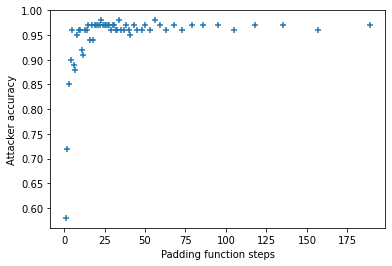

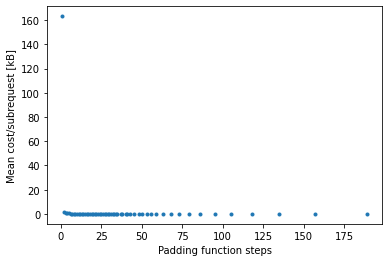

In [63]:
to_plot = []

for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perfs: # if the attack was not run, skip
        continue
    if len(cuts) == last_size: # skips repeat due to rounding in np.linrange
        continue

    last_size = len(cuts)
    acc = round(clf_perfs[len(cuts)]['score']['accuracy'][0], 2)
    top_f = [feature_name for feature_name, *_ in clf_perfs[len(cuts)]['features'][:3]]
 
    to_plot.append([len(cuts), med_cost, acc])

len_cuts = [row[0] for row in to_plot]
mean_costs = [row[1]/1024 for row in to_plot]
accs = [row[2] for row in to_plot]

plt.scatter(len_cuts, accs, marker="+")
plt.ylabel("Attacker accuracy")
plt.xlabel("Padding function steps")
plt.show()
plt.scatter(len_cuts, mean_costs, marker=".")
plt.ylabel("Mean cost/subrequest [kB]")
plt.xlabel("Padding function steps")
plt.show()

In [64]:
if False:
    data_short = dict()
    data_short['x'] = data['online-slots.co']
    res = get_features(data_short)
    feature_names = res['feature_names']
    print(feature_names)

feature_type = dict()
feature_type["n_incoming"] = "aggregate"
feature_type["n_outgoing"] = "aggregate"
feature_type["n_total"] = "aggregate"
feature_type["%_in"] = "aggregate"
feature_type["%_out"] = "aggregate"
feature_type["bytes_incoming"] = "aggregate"
feature_type["bytes_outgoing"] = "aggregate"
feature_type["bytes_total"] = "aggregate"
feature_type["bytes_%_in"] = "aggregate"
feature_type["bytes_%_out"] = "aggregate"
feature_type["times_sum"] = "aggregate"
feature_type["time_p25"] = "aggregate"
feature_type["time_p50"] = "aggregate"
feature_type["time_p75"] = "aggregate"
feature_type["time_p100"] = "aggregate"
feature_type["time_incoming_p25"] = "aggregate"
feature_type["time_incoming_p50"] = "aggregate"
feature_type["time_incoming_p75"] = "aggregate"
feature_type["time_incoming_p100"] = "aggregate"
feature_type["time_outgoing_p25"] = "aggregate"
feature_type["time_outgoing_p50"] = "aggregate"
feature_type["time_outgoing_p75"] = "aggregate"
feature_type["time_outgoing_p100"] = "aggregate"

feature_type["intertime_incoming_max"] = "local"
feature_type["intertime_incoming_avg"] = "local"
feature_type["intertime_incoming_std"] = "local"
feature_type["intertime_incoming_p75"] = "local"
feature_type["intertime_outgoing_max"] = "local"
feature_type["intertime_outgoing_avg"] = "local"
feature_type["intertime_outgoing_std"] = "local"
feature_type["intertime_outgoing_p75"] = "local"
feature_type["intertime_max"] = "local"
feature_type["intertime_avg"] = "local"
feature_type["intertime_std"] = "local"
feature_type["intertime_p75"] = "local"

feature_type["f30_n_incoming"] = "local"
feature_type["f30_n_outgoing"] = "local"
feature_type["l30_n_incoming"] = "local"
feature_type["l30_n_outgoing"] = "local"

feature_type["delta_rate_avg"] = "local"
feature_type["delta_rate_std"] = "local"
feature_type["delta_rate_p50"] = "local"
feature_type["delta_rate_min"] = "local"
feature_type["delta_rate_max"] = "local"
feature_type["delta_rate_1"] = "local"
feature_type["delta_rate_2"] = "local"
feature_type["delta_rate_3"] = "local"
feature_type["delta_rate_4"] = "local"
feature_type["delta_rate_5"] = "local"
feature_type["delta_rate_6"] = "local"
feature_type["delta_rate_7"] = "local"
feature_type["delta_rate_8"] = "local"
feature_type["delta_rate_9"] = "local"
feature_type["delta_rates_20_0"] = "local"
feature_type["delta_rates_20_1"] = "local"
feature_type["delta_rates_20_2"] = "local"
feature_type["delta_rates_20_3"] = "local"
feature_type["delta_rates_20_4"] = "local"
feature_type["delta_rates_20_5"] = "local"
feature_type["delta_rates_20_6"] = "local"
feature_type["delta_rates_20_7"] = "local"
feature_type["delta_rates_20_8"] = "local"
feature_type["delta_rates_20_9"] = "local"
feature_type["delta_rates_20_10"] = "local"
feature_type["delta_rates_20_11"] = "local"
feature_type["delta_rates_20_12"] = "local"
feature_type["delta_rates_20_13"] = "local"
feature_type["delta_rates_20_14"] = "local"
feature_type["delta_rates_20_15"] = "local"
feature_type["delta_rates_20_16"] = "local"
feature_type["delta_rates_20_17"] = "local"
feature_type["delta_rates_20_18"] = "local"
feature_type["delta_rates_20_19"] = "local"
feature_type["delta_rates_20_sum"] = "local"
feature_type["hist_0"] = "local"
feature_type["hist_334"] = "local"
feature_type["hist_669"] = "local"
feature_type["hist_1003"] = "local"
feature_type["hist_1337"] = "local"
feature_type["hist_1672"] = "local"
feature_type["hist_2006"] = "local"
feature_type["hist_2341"] = "local"
feature_type["hist_2675"] = "local"
feature_type["hist_3009"] = "local"
feature_type["hist_3344"] = "local"
feature_type["hist_3678"] = "local"
feature_type["hist_4012"] = "local"
feature_type["hist_4347"] = "local"
feature_type["hist_4681"] = "local"
feature_type["hist_5016"] = "local"
feature_type["hist_5350"] = "local"
feature_type["hist_5684"] = "local"
feature_type["hist_6019"] = "local"
feature_type["hist_6353"] = "local"
feature_type["hist_6687"] = "local"
feature_type["hist_7022"] = "local"
feature_type["hist_7356"] = "local"
feature_type["hist_7690"] = "local"
feature_type["hist_8025"] = "local"
feature_type["hist_8359"] = "local"
feature_type["hist_8694"] = "local"
feature_type["hist_9028"] = "local"
feature_type["hist_9362"] = "local"
feature_type["hist_9697"] = "local"
feature_type["hist_10031"] = "local"
feature_type["hist_10365"] = "local"
feature_type["hist_10700"] = "local"
feature_type["hist_11034"] = "local"
feature_type["hist_11368"] = "local"
feature_type["hist_11703"] = "local"
feature_type["hist_12037"] = "local"
feature_type["hist_12372"] = "local"
feature_type["hist_12706"] = "local"
feature_type["hist_13040"] = "local"
feature_type["hist_13375"] = "local"
feature_type["hist_13709"] = "local"
feature_type["hist_14043"] = "local"
feature_type["hist_14378"] = "local"
feature_type["hist_14712"] = "local"
feature_type["hist_15047"] = "local"
feature_type["hist_15381"] = "local"
feature_type["hist_15715"] = "local"
feature_type["hist_16050"] = "local"

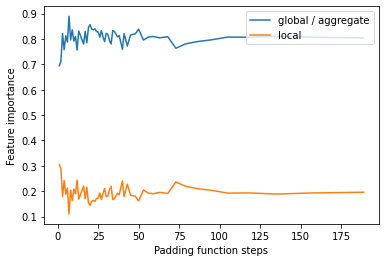

In [65]:
# understand how features evolve
def find_importance(features_and_importance, feature_name):
    for feature, importance, _ in features_and_importance:
        if feature == feature_name:
            return importance

    return 0

def sum_all_matching2(features_and_importance, keyword):
    su = 0
    for feature, importance, _ in features_and_importance:
        if feature_type[feature] == keyword:
            su += importance

    return su

tuples = []

for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perfs: # if the attack was not run, skip
        continue

    features = clf_perfs[len(cuts)]['features']
    tuples.append([len(cuts), sum_all_matching2(features, "aggregate"), sum_all_matching2(features, "local")])

xs = [t[0] for t in tuples]
ys1 = [t[1] for t in tuples]
ys2 = [t[2] for t in tuples]

plt.subplot(1, 1, 1)
plt.plot(xs, ys1, label="global / aggregate")
plt.plot(xs, ys2, label="local")
plt.xlabel("Padding function steps")
plt.ylabel("Feature importance")
plt.legend(loc='upper right')
plt.show()
    